#HW: Sentece contrastive learning

 This homework is about learning sentence representation and contrastive learning.


 From previous homework, we used to build token/sequence classification task and learn it through only supervised method. In real-world scenario, **human annotation** requires a lot of cost and effort to do. Some annotation tasks might require domain experts such as medical domain, legal domain, etc. However, there are some **unsupervised** methods which are no need any annotations.


 **Contrastive learning** is the popular one of unsupervised learning approach. It will learn the representation via similar and dissimilar examples.

 For this homework, we will focus on **SimCSE** framework which is one of contrastive learning techniques. For SimCSE, it will learn sentence embedding by comparing between different views of the same sentence.

 In this homework you will perform three main tasks.

1.   Train a sentiment classification model using a pretrained model. This model uses freeze weights. That is it treats the pretrained model as a fixed feature extractor.
2.   Train a sentiment classification model using a pretrained model. This model also performs weight updates on the base model's weights.
3.   Perform SimCSE and use the sentence embedding to perform linear classification.




## Install and import libraries

Install the `datasets` library under Huggingface and `Pytorch lightning` framework.

In [ ]:
!pip install datasets pytorch-lightning scikit-learn

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, AutoModel
)
from datasets import load_dataset
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Setup

The dataset we use for this homework is **Wisesight-Sentiment** ([huggingface](https://huggingface.co/datasets/pythainlp/wisesight_sentiment?row=3), [github](https://github.com/PyThaiNLP/wisesight-sentiment)) dataset. It is a Thai social media dataset which are labeled as **4 classes** e.g. positive, negative, neutral, and question. Furthermore, It contains both Thai, English, Emoji, and etc. That is why we choose the distilled version of multilingual BERT (mBERT) [DistilledBERT paper](https://arxiv.org/abs/1910.01108) to be a base model.

In [ ]:
model_name = 'distilbert-base-multilingual-cased'
dataset = load_dataset('pythainlp/wisesight_sentiment')

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name) # Or a Thai-specific tokenizer if available

## Loading Dataset and DataLoader

### Preprocessing step

In [ ]:
# Preprocessing function
def preprocess_function(examples):
    return tokenizer(examples['texts'], padding='max_length', truncation=True)

# Apply preprocessing
encoded_dataset = dataset.map(preprocess_function, batched=True)

# Change `category` key to `labels`
encoded_dataset = encoded_dataset.map(lambda examples: {'labels': [label for label in examples['category']]}, batched=True)


### Define Dataset class

In [ ]:
# Create PyTorch Dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(val) for key, val in self.encodings[idx].items()
            if key in ['input_ids', 'attention_mask']
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


### Declare Dataset and DataLoader

In [ ]:
# Create Dataset object from DataFrame
train_dataset = SentimentDataset(encoded_dataset['train'], encoded_dataset['train']['labels'])
val_dataset = SentimentDataset(encoded_dataset['validation'], encoded_dataset['validation']['labels'])
test_dataset = SentimentDataset(encoded_dataset['test'], encoded_dataset['test']['labels'])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Define base model classes

Here we define model classes which will be used in the next sections.

### Base Model class

`BaseModel` is a parent class for building other models e.g.
- `Pretrained LM with a linear classifier`
- `Fine-tuned LM with a linear classifier`
- `Contrastive learning based (SimCSE) LM with a linear classifier`

In [ ]:
class BaseModel(LightningModule):
    def __init__(
          self,
          model_name: str = 'distilbert-base-multilingual-cased',
          learning_rate: float = 2e-5
    ):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = AutoModel.from_pretrained(model_name)
        self.learning_rate = learning_rate

    def get_embeddings(self, input_ids, attention_mask):
        # TODO 1: get CLS token embedding to represent as a sentence embedding
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def forward(self, input_ids, attention_mask):
        return self.get_embeddings(input_ids, attention_mask)

### LMWithLinearClassifier class

`LMWithLinearClassifier` class is designed to update both LM's parameters in the supervised approach and a linear layer's parameters.

`LMWithLinearClassfier` consists of
1. `ckpt_path` (checkpoint path) refers to the best checkpoint after training SimCSE method. We will load the encoder's weights from the checkpoint into the local encoder. This parameter will be in the section of training a linear classifier after SimCSE training part.
2. `freeze_weights` function is to convert the training status of encoder's weights to non-trainable. This function will be used in the linear classifier training part under both `Pretrained LM with a linear classifier` and `SimCSE with a linear classifier`.
3. `freeze_encoder_weights` is defined to choose whether freeze or unfreeze encoder's weights.

In [ ]:
class LMWithLinearClassfier(BaseModel):
    def __init__(
          self,
          model_name: str = 'distilbert-base-multilingual-cased',
          ckpt_path: str = None,
          learning_rate: float = 2e-5,
          freeze_encoder_weights: bool = False
    ):
        super().__init__(
            model_name,
            learning_rate
        )
        self.save_hyperparameters()

        # TODO 2: load encoder's weights from Pytorch Lightning's checkpoint
        pass

        # TODO 3: define a linear classifier which will output the 4 classes
        pass

        if freeze_encoder_weights:
          self.freeze_weights(self.encoder)  # Freeze model

        self.accuracy = Accuracy(task='multiclass', num_classes=4)

    # TODO 4: implement `freeze_weights` function which will set requires_grad
    # in the model.parameters() so that no gradient update will be done on the
    # base model. Only the linear_layer will be updated.
    def freeze_weights(self, model):
        pass

    # TODO 5: get logits from the classifier
    def forward(self, input_ids, attention_mask):
        pass

    def training_step(self, batch, batch_idx):
        # TODO 6.1: implement cross entropy loss for text classification
        # and log loss and acc
        pass

    def validation_step(self, batch, batch_idx):
        # TODO 6.2: implement same as `training_step`
        pass

    def test_step(self, batch, batch_idx):
        # TODO 6.3: implement same as `training_step`
        pass

## Pretrained LM with a linear classifier

To benchmark models, we need to have some baselines to compare how good the models' perfomance are.


The simplest baseline to measure the contrastive learning-based method is the pretrained LM which just fine-tunes only the last linear classifier head to predict sentiments (positive/negative/neutral/questions).

### Define model

In [ ]:
pretrained_lm_w_linear_model = LMWithLinearClassfier(
    model_name,
    ckpt_path=None,
    freeze_encoder_weights=True
)

### Train a linear classifier

In [ ]:
# Create a ModelCheckpoint callback (recommended way):
pretrained_lm_w_linear_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_acc",  # Metric to monitor
    mode="max",  # "min" for loss, "max" for accuracy
    save_top_k=1,  # Save only the best model(s)
    save_weights_only=True, # Saves only weights, not the entire model
    dirpath="./checkpoints/", # Path where the checkpoints will be saved
    filename="best_pretrained_w_linear_model-{epoch}-{val_acc:.2f}", # Customized name for the checkpoint
    verbose=True,
)

# Initialize trainer
pretrained_lm_w_linear_trainer = Trainer(
    max_epochs=3,
    accelerator='auto',
    callbacks=[pretrained_lm_w_linear_checkpoint_callback], # Add the ModelCheckpoint callback
    gradient_clip_val=1.0,
    precision=16, # Mixed precision training
    devices=1,
)

# Train the model
pretrained_lm_w_linear_trainer.fit(pretrained_lm_w_linear_model, train_loader, val_loader)

### Evaluate

In [ ]:
pretrained_lm_w_linear_result = pretrained_lm_w_linear_trainer.test(pretrained_lm_w_linear_model, test_loader)
pretrained_lm_w_linear_result

## 2) Fine-tuned LM

This is the same as part 1, but you will also gradient update on the base model weights.

### Define model

In [ ]:
finetuned_lm_w_linear_model = LMWithLinearClassfier(
    model_name,
    ckpt_path=None,
    freeze_encoder_weights=False
)

### Train both LM and a linear classifier

In [ ]:
# Create a ModelCheckpoint callback (recommended way):
finetuned_lm_w_linear_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_acc",  # Metric to monitor
    mode="max",  # "min" for loss, "max" for accuracy
    save_top_k=1,  # Save only the best model(s)
    save_weights_only=True, # Saves only weights, not the entire model
    dirpath="./checkpoints/", # Path where the checkpoints will be saved
    filename="best_finetuned_w_linear_model-{epoch}-{val_acc:.2f}", # Customized name for the checkpoint
    verbose=True,
)

# Initialize trainer
finetuned_lm_w_linear_trainer = Trainer(
    max_epochs=3,
    accelerator='auto',
    callbacks=[finetuned_lm_w_linear_checkpoint_callback], # Add the ModelCheckpoint callback
    gradient_clip_val=1.0,
    precision=16, # Mixed precision training
    devices=1,
)

# Train the model
finetuned_lm_w_linear_trainer.fit(finetuned_lm_w_linear_model, train_loader, val_loader)

### Evaluate

In [ ]:
finetuned_lm_w_linear_result = finetuned_lm_w_linear_trainer.test(finetuned_lm_w_linear_model, test_loader)
finetuned_lm_w_linear_result

## Contrastive-based model (SimCSE) with a linear classifier


**SimCSE** (Simple Contrastive Learning of Sentence Embeddings) is a self-supervised learning method that learns high-quality sentence embeddings without relying on any labeled data.  It leverages contrastive learning, a technique where similar examples are encouraged to have similar representations, while dissimilar examples are pushed apart in representation space.

Here's the core idea in a nutshell:

- **Data Augmentation**:  SimCSE starts with a batch of sentences. For each sentence, it creates two slightly different "views" of the same sentence.  These views are created through simple augmentations, like dropout (randomly masking some words) or other minor perturbations.  These augmented sentences are semantically similar to the original.

- **Contrastive Objective**: The core of SimCSE is a contrastive loss function.  It treats the two different views of the same sentence as a positive pair – the model should learn to make their embeddings similar.  All other sentences in the batch (including their augmented versions) are treated as negative pairs – their embeddings should be dissimilar.

- **Learning**: The model is trained to minimize this contrastive loss.  This forces the model to learn sentence embeddings that are robust to the augmentations and capture the underlying semantic meaning of the sentences.  Sentences with similar meanings will have embeddings close together, while sentences with different meanings will have embeddings far apart.

Paper: https://arxiv.org/pdf/2104.08821.pdf


**Unsupervised SimCSE** is the foundation of the SimCSE method. It's a way to learn sentence embeddings without any labeled data.

**Core idea of its concept**

- **Dropout as Augmentation**: The key idea in unsupervised SimCSE is to use dropout (randomly masking some words during training) as a form of minimal data augmentation.

- **Two Views**: When you feed the same sentence through your transformer model twice, with dropout turned on, you get two slightly different representations (embeddings) of that sentence. These are like two "views" of the same sentence.

- **Contrastive Learning**: The two embeddings of the same sentence (the "views") are treated as a positive pair. The model is trained to make these embeddings similar to each other.
The embeddings of different sentences in the batch are treated as negative pairs. The model is trained to make these embeddings dissimilar to each other.


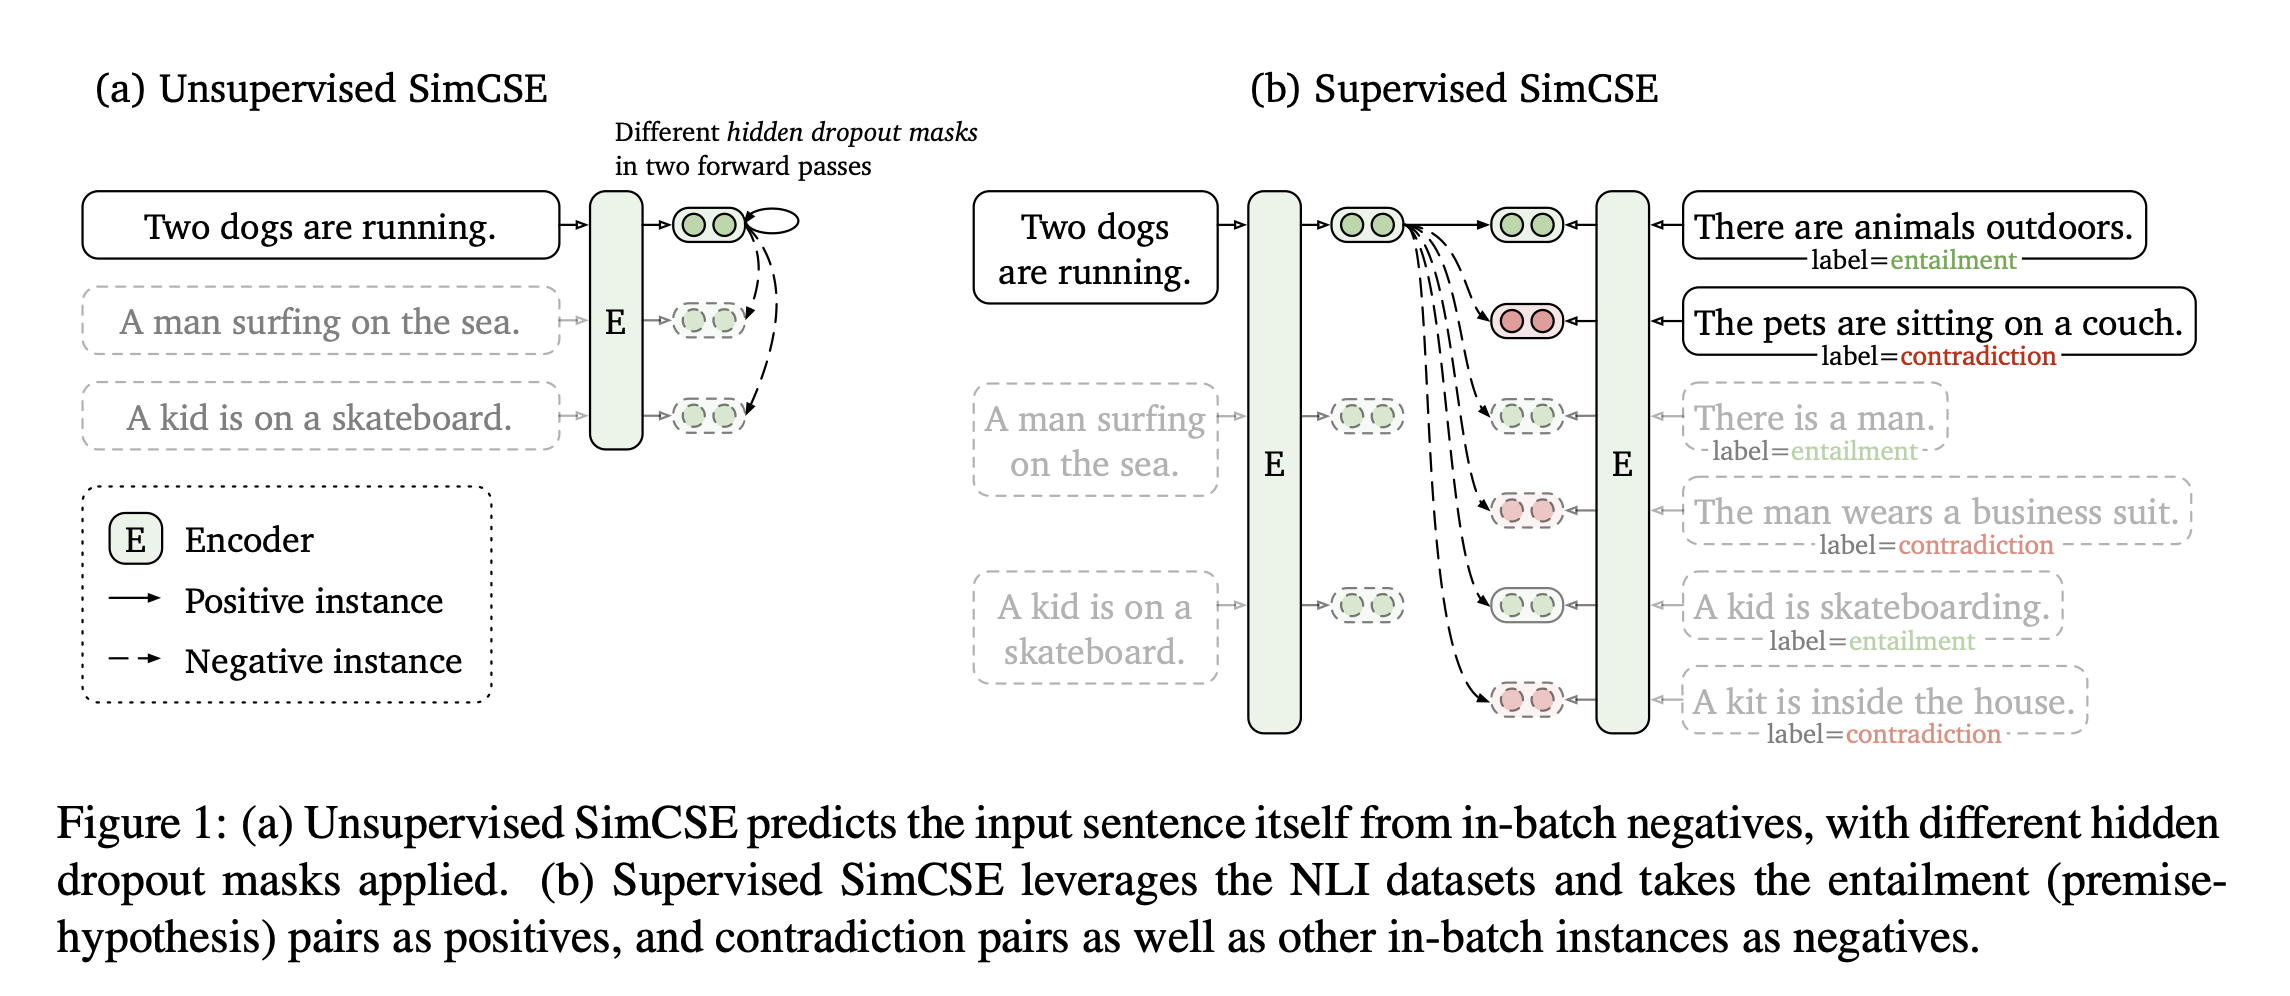

### Defined Unsupervised SimCSE model and InfoNCE loss

$L_{UnsupervisedInfoNCE} = -\log\frac{e^{cos(z_i, z_j) / \tau}}{e^{cos(z_i, z_j) / \tau} \cdot \sum\limits_{k=0}^N{(e^{cos(z_i, z_k) / \tau}})}$

**Notation**

$z_i$ indicates the anchor representation (the representation that we are focusing on). The anchor sentence is the initial sentence which its representation is augmented by the dropout masking layer.

$z_j$ indicates the positive representation (the representation that has the same semantic direction). The positive sentence is the same sentence as the anchor one but the positive representation is augmented in different way by the same dropout masking layer.

$z_k$ indicates the negative representation (the representation that has the opposite semantic direction). The negative sentence are the other sentences sampled besides the anchor/positive sentence.

$cos(\cdot, \cdot)$ is cosine similairity function

$N$ is the number of negative examples

**Hint**

For loss calculation section, I suggest you to use `F.crossentropy` function and the idea of in-batch negative sampling.






In [ ]:
class UnsupervisedSimCSE(BaseModel):
    def __init__(
          self,
          model_name: str = 'distilbert-base-multilingual-cased',
          learning_rate: float = 2e-6,
          temperature: float = 0.05,
    ):
        super().__init__(
            model_name,
            learning_rate
        )
        self.save_hyperparameters()
        self.temperature = temperature

        # TODO 7: enable dropout masking in transformer layers to do data augmentation
        # Dropout layers behave differently during training and inference
        # https://discuss.pytorch.org/t/if-my-model-has-dropout-do-i-have-to-alternate-between-model-eval-and-model-train-during-training/83007/2
        pass

    def forward(self, input_ids, attention_mask):
        # TODO 8: get sentence embeddings
        pass

    def training_step(self, batch, batch_idx):
        # TODO 9.1: implement unsupervised InfoNCE loss
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        # First forward pass
        embeddings1 = self(input_ids, attention_mask)

        # Second forward pass with different dropout
        embeddings2 = self(input_ids, attention_mask)

        ## Combine embeddings

        ## Calculate loss

        ## Log loss

        pass

    def validation_step(self, batch, batch_idx):
        # TODO 9.2: implement the same as `training_step`
        pass

    def test_step(self, batch, batch_idx):
        # TODO 9.3: implement the same as `training_step`
        pass

### Train LM through SimCSE approach

In [ ]:
# Initialize model
model = UnsupervisedSimCSE()

# Initialize trainer
simcse_trainer = Trainer(
    max_epochs=3,
    accelerator='auto',
    devices=1,
    gradient_clip_val=1.0,
    precision=16  # Mixed precision training
)

# Train the model
simcse_trainer.fit(model, train_loader)

# Save the latest checkpoint
simcse_trainer.save_checkpoint('/content/latest_simcse_checkpoint.ckpt')

### Define SimCSE with a linear classifier model

After training SimCSE on the data, we proceed to train a linear classifier on top of the trained model. Be sure to freeze the encoder weights.


In [ ]:
latest_simcse_ckpt_path = '/content/latest_simcse_checkpoint.ckpt'

simcse_lm_w_linear_model = LMWithLinearClassfier(
    model_name,
    ckpt_path=latest_simcse_ckpt_path,
    freeze_encoder_weights=True
)

### Train a linear classifier

In [ ]:
# Create a ModelCheckpoint callback (recommended way):
simcse_lm_w_linear_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_acc",  # Metric to monitor
    mode="max",  # "min" for loss, "max" for accuracy
    save_top_k=1,  # Save only the best model(s)
    save_weights_only=True, # Saves only weights, not the entire model
    dirpath="./checkpoints/", # Path where the checkpoints will be saved
    filename="best_simcse_linear_model-{epoch}-{val_acc:.2f}", # Customized name for the checkpoint
    verbose=True,
)

# Initialize trainer
simcse_lm_w_linear_trainer = Trainer(
    max_epochs=3,
    accelerator='auto',
    callbacks=[simcse_lm_w_linear_checkpoint_callback], # Add the ModelCheckpoint callback
    gradient_clip_val=1.0,
    precision=16, # Mixed precision training
    devices=1,
)

# Train the model
simcse_lm_w_linear_trainer.fit(simcse_lm_w_linear_model, train_loader, val_loader)

### Evaluate

In [ ]:
simcse_lm_w_linear_result = simcse_lm_w_linear_trainer.test(simcse_lm_w_linear_model, test_loader)
simcse_lm_w_linear_result